# Предобученные модели и трансферное обучение

Обучение CNN может занять много времени, и для этой задачи требуется много данных. Тем не менее, большая часть времени тратится на обучения низкоуровневых фильтров, которые сеть использует для извлечения шаблонов из изображений. Возникает закономерный вопрос – можно ли использовать нейронную сеть, обученную на одном наборе данных, и адаптировать ее к классификации разных изображений без полноценного процесса обучения?

Такой подход называется **трансферным обучением** (**transfer learning**), потому что мы переносим некоторые знания из одной нейросетевой модели в другую. В этом случае мы обычно начинаем с предобученной модели, натренированной на некотором большом датасете, таком как **ImageNet**. Эти модели уже могут хорошо извлекать различные признаки из общих изображений общего характера, и во многих случаях просто создание классификатора поверх этих извлеченных объектов может дать хороший результат.

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

### Датасет "Кошки против собак"

В этом разделе мы решим реальную задачу классификации изображений кошек и собак. Мы будем использовать [датасет Cats vs. Dogs](https://www.kaggle.com/c/dogs-vs-cats) с Kaggle, который также можно загрузить [с сайта Microsoft](https://www.microsoft.com/en-us/download/details.aspx).

Давайте загрузим этот набор данных и извлечем его в каталог 'data' (этот процесс может занять некоторое время!):

In [3]:
if not os.path.exists('data/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [4]:
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Этот датасет очень похож на реальные данные, в том смысле, что в наборе есть некоторые поврежденные файлы. Автоматически проверим и удалим повреждённые файлы:

In [5]:
import glob
from PIL import Image

def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return im.format=='JPEG'
    except:
        return False
    
def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print("Corrupt image or wrong format: {}".format(fn))
            os.remove(fn)

check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image or wrong format: data/PetImages/Cat\10073.jpg
Corrupt image or wrong format: data/PetImages/Cat\10125.jpg
Corrupt image or wrong format: data/PetImages/Cat\10404.jpg
Corrupt image or wrong format: data/PetImages/Cat\10501.jpg
Corrupt image or wrong format: data/PetImages/Cat\10820.jpg
Corrupt image or wrong format: data/PetImages/Cat\10874.jpg
Corrupt image or wrong format: data/PetImages/Cat\11083.jpg
Corrupt image or wrong format: data/PetImages/Cat\11086.jpg
Corrupt image or wrong format: data/PetImages/Cat\11095.jpg
Corrupt image or wrong format: data/PetImages/Cat\11210.jpg
Corrupt image or wrong format: data/PetImages/Cat\11397.jpg
Corrupt image or wrong format: data/PetImages/Cat\1151.jpg
Corrupt image or wrong format: data/PetImages/Cat\11565.jpg
Corrupt image or wrong format: data/PetImages/Cat\11729.jpg
Corrupt image or wrong format: data/PetImages/Cat\11864.jpg
Corrupt image or wrong format: data/PetImages/Cat\11874.jpg
Corrupt image or wrong format: data/PetIm

c:\winapp\conda\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupt image or wrong format: data/PetImages/Dog\9145.jpg
Corrupt image or wrong format: data/PetImages/Dog\9188.jpg
Corrupt image or wrong format: data/PetImages/Dog\9367.jpg
Corrupt image or wrong format: data/PetImages/Dog\9414.jpg
Corrupt image or wrong format: data/PetImages/Dog\9500.jpg
Corrupt image or wrong format: data/PetImages/Dog\9556.jpg
Corrupt image or wrong format: data/PetImages/Dog\9640.jpg
Corrupt image or wrong format: data/PetImages/Dog\9643.jpg
Corrupt image or wrong format: data/PetImages/Dog\9851.jpg
Corrupt image or wrong format: data/PetImages/Dog\9961.jpg
Corrupt image or wrong format: data/PetImages/Dog\9967.jpg


## Загрузка набора данных

В предыдущих примерах мы загружали наборы данных, встроенные в Keras. Теперь мы собираемся иметь дело с нашим собственным набором данных, который нам нужно загрузить из некоторой директории.

Размер датасетов изображений может быть довольно большим, и нельзя полагаться на то, что все данные смогут поместиться в памяти. Для загрузки наборов данных часто используют **генераторы**, которые считывают данные с диска по мере надобности и возвращают минибатчи, используемые при обучении.

Для задачи классификации изображений, Keras содержит функцию 'image_dataset_from_directory', которая  загружает изображения из подкаталогов, соответствующих различным классам. Эта функция также заботится о масштабировании изображений, а также может разделять набор данных на обучающие и тестовые выборки:

In [3]:
data_dir = 'data/PetImages'
batch_size = 64
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

Found 24769 files belonging to 2 classes.
Using 19816 files for training.
Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


Важно использовать одно и то же значение `seed` для обоих вызовов, так как оно влияет на разделение изображений между обучающим и тестовым набором данных.

Keras автоматически использует имена классов в соответствии с названиями подкаталогов:

In [4]:
ds_train.class_names

['Cat', 'Dog']

Полученные наборы данных могут быть непосредственно переданы в функцию `fit` для обучения модели. Они содержат как соответствующие изображения, так и метки. Вот пример того, как мы можем обращаться к данным:

In [5]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break

Training batch shape: features=(64, 224, 224, 3), labels=(64,)


Попробуем посмотреть на изображения из датасета:

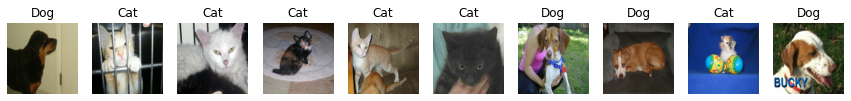

In [14]:
def display_dataset(dataset, labels=None, n=10, classes=None):
    fig,ax = plt.subplots(1,n,figsize=(15,3))
    for i in range(n):
        ax[i].imshow(dataset[i])
        ax[i].axis('off')
        if classes is not None and labels is not None:
            ax[i].set_title(classes[labels[i][0]])
    
display_dataset(x_sample.numpy().astype(int),np.expand_dims(y_sample,1),classes=ds_train.class_names)

> **Примечание**: Все изображения в наборе данных представлены в виде тензоров с плавающей запятой с диапазоном 0-255. Прежде чем передать их в нейронную сеть, нам нужно масштабировать эти значения в диапазоне 0-1. При отображении изображений нам нужно либо сделать то же самое, либо преобразовать значения в тип 'int' (что мы и делаем в приведенном выше коде), чтобы показать `matplotlib`, что мы хотим отобразить исходное немасштабированное изображение.

## Предобученные модели

Для многих задач классификации изображений можно найти предварительно обученные модели нейронных сетей. Многие из этих моделей доступны в пространстве имен `keras.applications`, и еще больше моделей можно найти в Интернете по ключевым словам **model zoo** (*зоопарк моделей*). Давайте посмотрим, как можно загрузить и использовать простейшую модель VGG-16:

In [7]:
vgg = keras.applications.VGG16()
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

553476096/553467096 [==============================] - 17s 0us/step
Most probable class = [234]
49152/35363 [=========================================] - 0s 1us/step


[[('n02106550', 'Rottweiler', 0.80610114),
  ('n02089078', 'black-and-tan_coonhound', 0.071738556),
  ('n02107312', 'miniature_pinscher', 0.02583869),
  ('n02107142', 'Doberman', 0.021859147),
  ('n02101006', 'Gordon_setter', 0.017213248)]]

Здесь есть несколько важных вещей:

* Перед передачей входных данных в большинство предобученных сетей их необходимо предобработать  определенным образом. В Keras это делается путем вызова соответствующей функции `preprocess_input`, которая получает пакет изображений и возвращает их обработанный результат. В случае VGG-16 изображения нормализуются, и из него вычитается некоторое предопределенное значение среднего для каждого из каналов. Это связано с тем, что VGG-16 изначально был обучен на изображениях с такой предварительной обработкой.
* Нейронная сеть применяется к входному пакету, и в результате мы получаем пакет 1000-элементных тензоров, которые показывают вероятность каждого класса. Мы можем найти наиболее вероятный номер класса, вызвав `argmax` на этом тензоре.
* Полученный результат является [номером класса `ImageNet`](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). Чтобы понять, что это за класс, мы также можем использовать функцию `decode_predictions`, которая возвращает верхние $n$ классов вместе с их именами.

Давайте также посмотрим на архитектуру сети VGG-16:

In [8]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Вычисления на GPU 

Глубокие нейронные сети, такие как VGG-16 и другие более современные архитектуры требуют довольно много вычислительной мощности для работы. Имеет смысл использовать ускорители GPU, если они доступны. К счастью, Keras автоматически ускоряет вычисления на графическом процессоре при его наличии. Мы можем проверить, доступен ли GPU, используя следующий код:

In [9]:
tf.config.list_physical_devices('GPU')

[]

В Google Colab для поддержки GPU необходимо в свойствах ноутбука поставить тип ускорителя GPU.

## Извлечение VGG-признаков

Пирамидальная архитектура VGG-16 устроена таким образом, что сначала идёт несколько свёрточных слоёв с пулингом, затем - слой `Flatten`, после чего поверх получившегося вектора используется несколько полносвязных слоёв классификаторв. Мы можем использовать VGG-16 для извлечения признаков из изображений, отбросив классификатор и используя полученный после свёрточных слоёв **вектор признаков**. В этом случае нам нужна модель без окончательных классификационных слоев, которую мы можем загрузить так:

58900480/58889256 [==============================] - 2s 0us/step
Shape after applying VGG-16: (7, 7, 512)


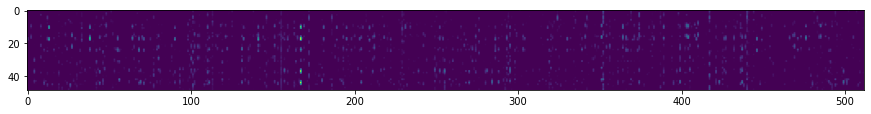

In [10]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)
print(f"Shape after applying VGG-16: {res[0].shape}")
plt.figure(figsize=(15,3))
plt.imshow(res[0].numpy().reshape(-1,512))

Размерность вектора признаков составляет 7x7x512, но для того, чтобы визуализировать его, нам пришлось преобразовать его в 2D-форму.

Теперь давайте используем эти признаки для классификации изображений. Возьмем некоторую часть изображений (50 минибатчей, в нашем случае) и предварительно вычислим их векторы признаков. Для этого мы можем использовать API Tensorflow **dataset**. Функция `map` принимает набор данных и применяет для его преобразования заданную функцию. Мы используем этот механизм для создания новых наборов данных, `ds_features_train` и `ds_features_test`, которые содержат извлеченные VGG признаки:

In [11]:
num = batch_size*50
ds_features_train = ds_train.take(50).map(lambda x,y : (vgg(x),y))
ds_features_test = ds_test.take(10).map(lambda x,y : (vgg(x),y))

for x,y in ds_features_train:
    print(x.shape,y.shape)
    break

(64, 7, 7, 512) (64,)


Мы использовали конструкцию `.take(50)` чтобы ограничить размер набора данных и ускорить нашу демонстрацию. Конечно, вы можете выполнить этот эксперимент с полным набором данных.

Теперь, когда у нас есть набор данных с извлеченными признаками, мы можем обучить простой полносвязный классификатор, чтобы различать кошек и собак. Эта сеть примет вектор формы 7x7x512 и выдаст один выход, который соответствует либо собаке, либо кошке. Поскольку это двоичная классификация, мы используем функцию активации сигмоид, и функцию потерь `binary_crossentropy`.

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,7,512)),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_features_train, validation_data=ds_features_test)

50/50 [==============================] - 797s 16s/step - loss: 1.5099 - acc: 0.9103 - val_loss: 1.9361 - val_acc: 0.9312


Результат отличный, мы можем отличить кошку от собаки почти c 95% вероятностью! Тем не менее, мы протестировали этот подход только на подмножестве всех изображений, потому что ручное извлечение признаков занимает много времени.

## Трансферное обучение с помощью единой сети VGG

Мы также можем избежать явного предварительного вычисления векторов признаков, используя предобученную сеть VGG-16 в нашей сети в качестве первого уровня. 

Прелесть архитектуры Keras заключается в том, что модель VGG-16, которую мы определили выше, также может быть использована в качестве слоя в другой нейронной сети! Нам просто нужно построить сеть с полносвязным классификатором поверх нее, а затем обучить всю сеть с помощью обратного распространения.

In [6]:
model = keras.models.Sequential()
model.add(keras.applications.VGG16(include_top=False,input_shape=(224,224,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


Эта модель представляет собой единую сеть классификации, которая принимает изображение и возвращает класс. Однако сложность заключается в том, что мы хотим, чтобы VGG16 действовал как экстрактор признаков, а не переобучался. Таким образом, нам нужно **заморозить веса** сверточного экстрактора признаков. Мы можем получить доступ к первому уровню сети, вызвав `model.layers[0]`, и нам просто нужно установить для свойства `trainable` значение `False`.

> **Примечание**: Замораживание весов экстрактора признаков необходимо, потому что в противном случае необученный слой классификатора может разрушить исходные предварительно обученные веса сверточного экстрактора.

Вы можете заметить, что, в то время как общее количество параметров в нашей сети составляет около 15 миллионов, мы обучаем только 25 тысяч параметров. Все остальные параметры сверточных фильтров верхнего уровня предварительно обучены и зафиксированы. Это хорошо, потому что мы можем точно настроить меньшее количество параметров с меньшим количеством примеров.

Теперь мы обучим нашу сеть и посмотрим на получившуюся точность. Время выполнения этого кода может быть значительным!

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_train, validation_data=ds_test)

310/310 [==============================] - 265s 716ms/step - loss: 0.9917 - acc: 0.9512 - val_loss: 0.8156 - val_acc: 0.9671


Похоже, мы получили достаточно точный классификатор кошек против собак! 

## Сохранение и загрузка модели

После того, как мы обучили модель, мы можем сохранить архитектуру модели и обученные веса в файл для будущего использования:

In [8]:
model.save('data/cats_dogs.tf')

INFO:tensorflow:Assets written to: data/cats_dogs.tf/assets


Затем мы можем загрузить модель из файла в любое время. Записывать модель полезно также и во время обучения, чтобы в случае возникновения проблем (отключения электричества) не потерять всю проделанную работу.

In [9]:
model = keras.models.load_model('data/cats_dogs.tf')

## Тонкая настройка фичеризатора

В предыдущем разделе мы обучили последний слой классификатора на нашем собственном наборе данных. Мы не переобучали экстрактор признаков VGG, и наша модель полагалась на паттерны, которым модель научилась на данных ImageNet. Если же наши объекты визуально сильно отличаются от обычных изображений ImageNet (например, мы работаем с рентгеновскими снимками), эта комбинация паттернов может работать не лучшим образом. В этом случае имеет смысл начать тренировать и сверточные слои.

Для этого мы можем разморозить параметры сверточного фильтра, которые мы ранее заморозили. 

> **Замечание:** Важно сначала заморозить параметры и выполнить несколько эпох тренировки, чтобы стабилизировать веса в классификационном слое. Если сразу начать обучение сквозной сети с незамороженными параметрами, то большие ошибки на начальном этапе скорее всего разрушат предобученные веса в сверточных слоях.

Наша сверточная модель VGG-16 расположена внутри первого слоя, и сама она состоит из множества слоев. Мы можем взглянуть на его структуру: 

In [10]:
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Разморозим все свёрточные слои:

In [ ]:
model.layers[0].trainable = True

Размораживать сразу все слои – не самая лучшая идея. Сначала мы можем разморозить только несколько последних слоев, потому что они содержат шаблоны более высокого уровня, которые имеют отношение к нашим изображениям. Например, для начала мы можем заморозить все слои, кроме последних 4: 

In [11]:
for i in range(len(model.layers[0].layers)-4):
    model.layers[0].layers[i].trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 7,104,513
Non-trainable params: 7,635,264
_________________________________________________________________


Обратите внимание, что количество обучаемых параметров значительно увеличилось, но оно по-прежнему составляет около 50% от всех параметров.

После размораживания мы можем сделать еще несколько эпох обучения (в нашем примере мы сделаем только одну). Вы также можете выбрать более низкую скорость обучения, чтобы свести к минимуму влияние на предварительно обученные веса. Тем не менее, даже при низкой скорости обучения вы можете ожидать, что точность упадет в начале тренировки, пока, наконец, не достигнет немного более высокого уровня, чем в случае фиксированных весов.

> **Примечание:** Это обучение происходит намного медленнее, потому что нам нужно распространять градиенты обратно через много слоев сети!

In [12]:
hist = model.fit(ds_train, validation_data=ds_test)

310/310 [==============================] - 201s 645ms/step - loss: 0.5270 - acc: 0.9776 - val_loss: 1.4132 - val_acc: 0.9653


Мы не будем тратить время и обучать модель до конца, но вы можете поэкспериментировать и посмотреть, удастся ли вам получить более высокую точность на тестовом датасете. Помните, что более мощная модель с большим количеством параметров склонна к переобучению!

## Другие модели компьютерного зрения

VGG-16 является одной из простейших архитектур свёрточных сетей для компьютерного зрения. Keras предоставляет гораздо больше предварительно обученных сетей. Наиболее часто используемыми из них являются архитектуры **ResNet**, разработанная Microsoft, и **Inception** от Google. Например, давайте рассмотрим архитектуру простейшей модели ResNet-50.

> ResNet — это семейство моделей с разной глубиной, можно попробовать поэкспериментировать с ResNet-152, если хотите посмотреть, как выглядит действительно глубокая модель.

In [16]:
resnet = keras.applications.ResNet50()
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Как видите, модель содержит те же привычные строительные блоки: сверточные слои, пулинговые слои и конечный плотный классификатор. Мы можем использовать эту модель точно так же, как мы использовали VGG-16 для трансферного обучения. Вы можете попробовать поэкспериментировать с приведенным выше кодом, используя различные модели ResNet в качестве базовой модели, и посмотреть, как изменяется точность.

## Выводы

Используя transfer learning, мы смогли быстро обучить классификатор для нашей задачи и достичь высокой точности со сравнительно небольшим количеством примеров. Однако, этот пример был не совсем справедливым, потому что оригинальная сеть VGG-16 была предварительно обучена распознавать и кошек, и собак - и мы просто повторно использовали большинство шаблонов, которые уже присутствовали в сети. Скорее всего на более экзотических объектах, таких, как детали на производственной линии на заводе, рентгеновские снимки иди или различные листья деревьев, можно ожидать сущесвенно более низкой точности.